<a href="https://colab.research.google.com/github/theostoican/Guided-Research/blob/main/gr_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install timm 
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

vitb16 = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224').to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 18.5 MB/s 
     |████████████████████████████████| 163 kB 61.8 MB/s 


Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [ ]:
!pip install torchinfo
from torchinfo import summary
# summary(vitb16, (1, 3, 224, 224))
vitb16.blocks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ModuleList(
  (0): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (drop_path): Identity()
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate=none)
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
  )
  (1): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropo

In [ ]:
for param in vitb16.parameters():
  param.required_grad = True


In [ ]:
!pip install transformers
from transformers import ViTFeatureExtractor
from PIL import Image
from torchvision import transforms as pth_transforms
import os
import torchvision

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')

def process_input(image):
  patch_size = 16

  transform = pth_transforms.Compose([
          pth_transforms.Resize((480, 480)),
          pth_transforms.ToTensor(),
          pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ])
  image = transform(image)

  w, h = image.shape[1] - image.shape[1] % patch_size, image.shape[2] - image.shape[2] % patch_size
  image = image[:, :w, :h].unsqueeze(0).to(device)

  return image

def process_output(image):

  transform = pth_transforms.Compose([
          pth_transforms.Resize((901, 901)),
          pth_transforms.ToTensor(),
      ])
  image = transform(image).to(device)

  return image

inputs = []
labels = []

for img_name in sorted(os.listdir(os.path.join('data', 'data'))):
  img = Image.open(os.path.join('data', 'data', img_name))
  input = process_input(img)
  inputs.append(input)

for img_name in sorted(os.listdir(os.path.join('data', 'labels'))):
  img = Image.open(os.path.join('data', 'labels', img_name))
  segmentation_map = process_output(img)
  labels.append(segmentation_map)

inputs = torch.stack(inputs).to(device)
labels = torch.stack(labels).to(device)

dataset = [(input, label) for (input, label) in zip(inputs, labels)]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


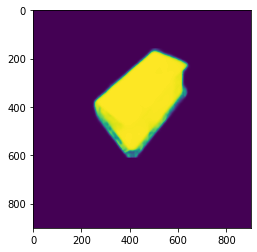

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
plt.imshow(F.to_pil_image(labels[50].detach()))

In [ ]:
output = vitb16(inputs[0])
vitb16.get_last_selfattention(inputs[0].to(device)).shape

torch.Size([1, 12, 901, 901])

In [ ]:
from torch import nn
import matplotlib.pyplot as plt

def save_attentions(inputs, attentions):
  attentions = attentions.detach()

  nh = attentions.shape[1] # number of heads


  patch_size = 16
  w, h = inputs.shape[-2] - inputs.shape[-2] % patch_size, inputs.shape[-1] - inputs.shape[-1] % patch_size
  inputs = inputs[:, :w, :h].unsqueeze(0)

  w_featmap = inputs.shape[-2] // patch_size
  h_featmap = inputs.shape[-1] // patch_size

  attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

  attentions = attentions.reshape(nh, w_featmap, h_featmap)
  attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

  print(attentions.shape)

  # save attentions heatmaps
  os.makedirs('maps', exist_ok=True)
  torchvision.utils.save_image(torchvision.utils.make_grid(inputs, normalize=True, scale_each=True),
                              os.path.join('maps', "img.png"))
  for j in range(nh):
      fname = os.path.join('maps', "attn-head" + str(j) + ".png")
      plt.imsave(fname=fname, arr=attentions[j], format='png')
      print(f"{fname} saved.")

save_attentions(inputs[0], vitb16.get_last_selfattention(inputs[0].to(device)))

(12, 480, 480)
maps/attn-head0.png saved.
maps/attn-head1.png saved.
maps/attn-head2.png saved.
maps/attn-head3.png saved.
maps/attn-head4.png saved.
maps/attn-head5.png saved.
maps/attn-head6.png saved.
maps/attn-head7.png saved.
maps/attn-head8.png saved.
maps/attn-head9.png saved.
maps/attn-head10.png saved.
maps/attn-head11.png saved.


In [ ]:
import torch.optim as optim

def my_loss(attentions, target):
  inverted_target = 1 - target
  loss = torch.mean((torch.mul(target, attentions[0]) - \
                     torch.mul(inverted_target, attentions[1])) ** 2) + \
         torch.mean((torch.mul(inverted_target, attentions[0]) - \
                     torch.mul(target, attentions[1])) ** 2)
  return loss

def train(model, inputs, labels, max_epochs = 100):
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(max_epochs):
    loss_avg = 0
    for (input, label) in zip(inputs, labels):
      optimizer.zero_grad()

      outputs = vitb16(input)
      attentions = vitb16.get_last_selfattention(input.to(device))[0]

      loss = my_loss(attentions, label)
      loss.backward()

      optimizer.step()

      loss_avg += loss.item()

    print(f'Epoch {epoch}, average loss: {loss_avg / len(dataset)}')


In [ ]:
print(labels.shape)
train(vitb16, inputs, labels[:, 0, :, :])

torch.Size([245, 1, 901, 901])
Epoch 0, average loss: 2.3993750281598685e-06
Epoch 1, average loss: 2.399344330857572e-06
Epoch 2, average loss: 2.3993048773486314e-06
Epoch 3, average loss: 2.3992655027244356e-06
Epoch 4, average loss: 2.399228620858167e-06
Epoch 5, average loss: 2.3991950818489554e-06
Epoch 6, average loss: 2.3991711417210707e-06


In [ ]:
save_attentions(dataset[50][0], vitb16.get_last_selfattention(dataset[50][0].to(device)))

(12, 480, 480)
maps/attn-head0.png saved.
maps/attn-head1.png saved.
maps/attn-head2.png saved.
maps/attn-head3.png saved.
maps/attn-head4.png saved.
maps/attn-head5.png saved.
maps/attn-head6.png saved.
maps/attn-head7.png saved.
maps/attn-head8.png saved.
maps/attn-head9.png saved.
maps/attn-head10.png saved.
maps/attn-head11.png saved.
